## OCR applied on kazakh license plates

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import imutils

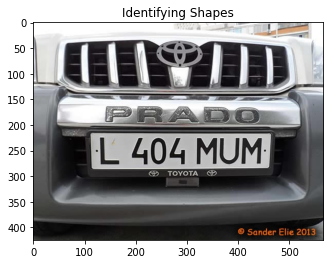

In [2]:
image_path = '404.jpeg'
image = cv2.imread(image_path)

plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.title('Identifying Shapes'); plt.show()

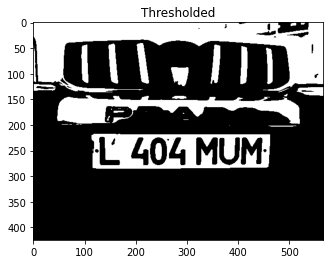

In [3]:
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
blurred = cv2.GaussianBlur(gray, (5, 5), 0)

threshold = 180
thresh = cv2.threshold(blurred, threshold, 255, cv2.THRESH_BINARY)[1]

plt.imshow(thresh, cmap='gray')
plt.title('Thresholded'); plt.show()

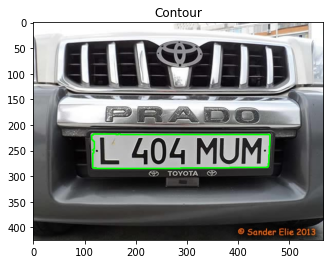

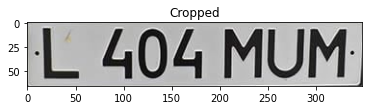

In [4]:
cnts = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cnts = imutils.grab_contours(cnts)

cropped_image = []

for c in cnts:
    peri = cv2.arcLength(c, True)
    approx = cv2.approxPolyDP(c, 0.05 * peri, True)

    if len(approx) == 4:
        x, y, w, h = cv2.boundingRect(approx)

        if w < 50: continue # exclude small contours

        imageCopy = image.copy()
        cv2.drawContours(imageCopy, [c], -1, (0, 255, 0), 2)

        plt.imshow(cv2.cvtColor(imageCopy, cv2.COLOR_BGR2RGB))
        plt.title('Contour'); plt.show()

        cropped_image = image[y:y+h, x:x+w]
        plt.imshow(cv2.cvtColor(cropped_image, cv2.COLOR_BGR2RGB))
        plt.title('Cropped'); plt.show()

        ar = w / float(h)
        if ar > 1.3: break # for square license plates

0.3266487455978392,0.0003140977721186254,2.2218781127167577e-05


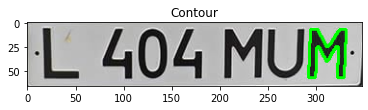

0.33502134338872913,0.00021257145405261432,9.888046880388531e-05


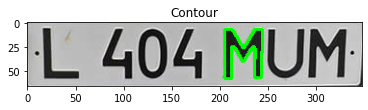

0.3763069729397715,0.033276717876175414,0.02221903872858956


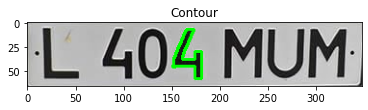

0.1816760268731839,0.0075451345880865476,3.49273654457626e-07


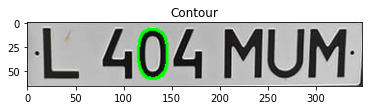

0.36122612027034806,0.029404175661090985,0.017996036815711863


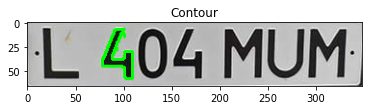

0.517180454745494,0.002158401974887947,0.009826344658010001


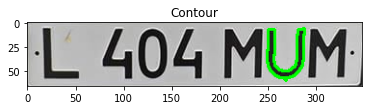

0.5611963702638134,0.14657556162183935,0.10898298566070601


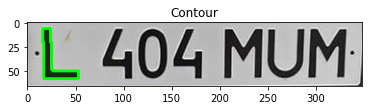

In [5]:
gray = cv2.cvtColor(cropped_image, cv2.COLOR_BGR2GRAY)
blurred = cv2.GaussianBlur(gray, (5, 5), 0)

thresh = cv2.threshold(gray, threshold, 255, cv2.THRESH_BINARY_INV)[1]

cnts = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cnts = imutils.grab_contours(cnts)

for c in cnts:
    imageCopy = cropped_image.copy()

    moments = cv2.moments(c) 
    huMoments = cv2.HuMoments(moments)
    h0, h1, h2 = huMoments[:3, 0]

    area = int(cv2.contourArea(c))   

    if area < 100: continue

    print(f'{h0},{h1},{h2}')

    cv2.drawContours(imageCopy, [c], -1, (0, 255, 0), 2)
    plt.imshow(cv2.cvtColor(imageCopy, cv2.COLOR_BGR2RGB))
    plt.title('Contour'); plt.show()

## Model for recognition using contour features

In [6]:
import sklearn
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
import pandas as pd

data = pd.read_csv('plates_dataset.csv')

X_cols = ['h0','h1','h2']
y_cols = ['digit']

standardScaler = StandardScaler()
data[X_cols] = standardScaler.fit_transform(data[X_cols])

X, y = data[X_cols], data[y_cols]

knn = KNeighborsClassifier()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

knn.fit(X_train, y_train.values.ravel())
knn_pred = knn.predict(X_test)
knn_accuracy = metrics.accuracy_score(y_test.values.ravel(), knn_pred)

print('Accuracy using knn: %f%%\n' % (knn_accuracy * 100))

Accuracy using knn: 77.419355%



In [7]:
knn = KNeighborsClassifier()
knn.fit(X, y.values.ravel())

KNeighborsClassifier()

In [8]:
def image_preprocess(image_path):
    image = cv2.imread(image_path)

    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)

    thresh = cv2.threshold(blurred, threshold, 255, cv2.THRESH_BINARY)[1]

    cnts = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)

    offset_x, offset_y = 0, 0
    cropped_image = []

    for c in cnts:
        peri = cv2.arcLength(c, True)
        approx = cv2.approxPolyDP(c, 0.05 * peri, True)

        if len(approx) == 4:
            x, y, w, h = cv2.boundingRect(approx)

            if w < 50: continue # exclude small contours

            imageCopy = image.copy()
            cv2.drawContours(imageCopy, [c], -1, (0, 255, 0), 2)

            plt.imshow(cv2.cvtColor(imageCopy, cv2.COLOR_BGR2RGB))
            plt.title('Contour'); plt.show()

            offset_x, offset_y = x, y
            cropped_image = image[y:y+h, x:x+w]
            plt.imshow(cv2.cvtColor(cropped_image, cv2.COLOR_BGR2RGB))
            plt.title('Cropped'); plt.show()

            ar = w / float(h)
            if ar > 1.3: break # square license plates

    gray = cv2.cvtColor(cropped_image, cv2.COLOR_BGR2GRAY)

    thresh = cv2.threshold(gray, threshold, 255, cv2.THRESH_BINARY_INV)[1]

    cnts = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)

    h0_arr, h1_arr, h2_arr, xy_arr = [], [], [], []

    for c in cnts:
        peri = cv2.arcLength(c, True)
        approx = cv2.approxPolyDP(c, 0.05 * peri, True)
        
        x, y, w, h = cv2.boundingRect(approx)

        moments = cv2.moments(c) 
        huMoments = cv2.HuMoments(moments)
        h0, h1, h2 = huMoments[:3, 0]

        area = int(cv2.contourArea(c))

        if area < 100: continue

        h0_arr.append(h0)
        h1_arr.append(h1)
        h2_arr.append(h2)
        xy_arr.append((x, y))

    d = {'h0': h0_arr, 'h1': h1_arr, 'h2': h2_arr}
    features = pd.DataFrame(data=d)

    return features, (offset_x, offset_y), xy_arr, image

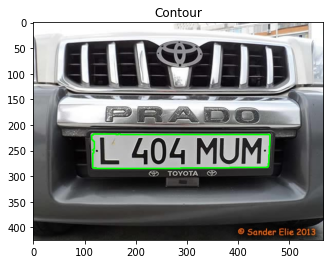

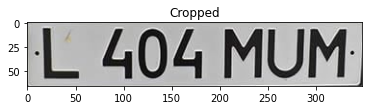

In [11]:
image_path = '404.jpeg'
test_data, (offset_x, offset_y), xy_arr, image = image_preprocess(image_path)

test_data[X_cols] = standardScaler.fit_transform(test_data[X_cols])

X = test_data[X_cols]

knn_pred = knn.predict(X)

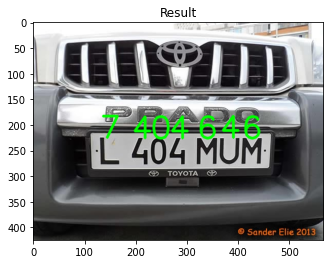

In [12]:
for i, digit in enumerate(knn_pred):
    font = cv2.FONT_HERSHEY_SIMPLEX
    org = (xy_arr[i][0] + offset_x, xy_arr[i][1] + offset_y)
    fontScale = 2
    color = (0, 255, 0)
    thickness = 3
    image = cv2.putText(image, str(digit), org, font,
                        fontScale, color, thickness, cv2.LINE_AA)

plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.title('Result'); plt.show()